# TRATAMIENTO DE DATOS ATÍPCOS Y DATOS FALTANTES

# Integrantes:

*   Tomás Rodríguez Taborda
*   Mariana Valencia Ríos



In [430]:
pip install pyod

In [431]:
pip install fancyimpute

In [432]:
#Paquetes a usar:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from scipy.stats import median_abs_deviation
from pyod.models.mad import MAD
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize
from sklearn.impute import KNNImputer
from fancyimpute  import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [433]:
#Desactivamos la notación científica
pd.options.display.float_format = "{:.2f}".format

#Elegimos ggplot como el estilo determinado de nuestras gráficas.
plt.style.use("ggplot")

# Punto 1:

A partir del dataset ruidoso.txt realice los siguientes análisis:

### **a.** Cargue y explore el dataset explicando en qué consiste y las características que posee el mismo.






In [434]:
#Ruta en la que se encuentran los respectivos dataframes:
os.chdir("/content")

#Leer la base de datos "ruidoso":
ruidoso= pd.read_csv('ruidoso.txt',sep=",", header=0)

In [435]:
#Vemos el tamaño de nuestro data frame
print(f"El tamaño del dataframe es de {ruidoso.shape}")

El tamaño del dataframe es de (66, 5)


In [436]:
#Como análisis exploratorio inicial vemos el encabezado y cola de los datos
print(f"Encabezado de la base de datos:\n{ruidoso.head()}\n")
print(f"Cola de la base de datos:\n{ruidoso.tail()}")


Encabezado de la base de datos:
   Unnamed: 0  Road_55dB  Road_60dB  Railways_65dB  Industry_65dB
0           1     166400      79200           1100           0.00
1           2      20000      11000              0           0.00
2           3      37800      18000              0           0.00
3           4      24500      16700              0         100.00
4           5     103100      33500           1900         200.00

Cola de la base de datos:
    Unnamed: 0  Road_55dB  Road_60dB  Railways_65dB  Industry_65dB
61          62      20700      16200              0           0.00
62          63      15100       9900              0           0.00
63          64      24500      12400            300         300.00
64          65      12800       8500              0           0.00
65          66    3108200    1469100          25800            NaN


Al observar el encabezado y cola de los datos del data frame "ruidoso", tenemos que la columna "Unnamed" no nos porporciona información relevante o que pueda ser útil dentro de un análisis, por lo tanto procedemos a eliminarla.

In [437]:
#Eliminamos la columna unnamed
ruidoso.drop("Unnamed: 0", axis = 1, inplace = True)

In [438]:
#Encabezado de la base de datos sin la columna "Unnamed"
ruidoso.head()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
0,166400,79200,1100,0.00
1,20000,11000,0,0.00
2,37800,18000,0,0.00
3,24500,16700,0,100.00
4,103100,33500,1900,200.00


In [439]:
#Tipo de variables del data frame
ruidoso.dtypes

Road_55dB          int64
Road_60dB          int64
Railways_65dB      int64
Industry_65dB    float64
dtype: object

Observamos los diferentes tipos de datos que tenemos en nuestro dataframe, podemos ver como todos son enteros a excepción de la cuarta columna que son números tipo float, es decir que tienen parte decimal.

In [440]:
#Cantidad de datos faltantes or columna dentro del data frame
ruidoso.isna().sum()

Road_55dB        0
Road_60dB        0
Railways_65dB    0
Industry_65dB    1
dtype: int64

En este caso la única columna que tiene datos de tipo NA es Industry_65db con una única observación de este tipo.

Tenemos un total de 66 observaciones y 4 columnas que parecen corresponder a los decibeles registrados en diferentes sitios, en dos carreteras, en unas vías de tren y un lugar con diferentes industrias.


1.   Road 55 dB
2.   Road 60 dB
3.   Railways 65 dB
4.   Industry 65 db


### **b.** Realice un breve análisis exploratorio para identificar la distribución de las variables usadas en la base de datos ¿será que existe relación entre las variables?

In [441]:
#Descripción inicial de los datos pertenecientes a cada columna
ruidoso.describe()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
count,66.00,66.00,66.00,65.00
mean,159228.79,78587.88,1139.39,180.00
std,484751.28,251408.98,4778.83,537.99
min,7600.00,4000.00,0.00,0.00
25%,18950.00,10075.00,0.00,0.00
50%,37550.00,17400.00,100.00,0.00
75%,78900.00,34500.00,400.00,100.00
max,3108200.00,1469100.00,29700.00,4000.00


Al momento de revisar el anterior resultado hay varias cosas que nos llaman la atención. Si revisamos la diferencia entre el mínimo y el 25% de nuestros datos hay un salto importante en la información para las dos primeras columnas, al igual que con el 75% y el máximo para las 4 columnas del dataframe. Lo anterior nos da sospechas de la posible presencia de datos atípicos para las 4 columnas

Text(0.5, 1.0, 'Railways 65dB vs Industry 65dB')

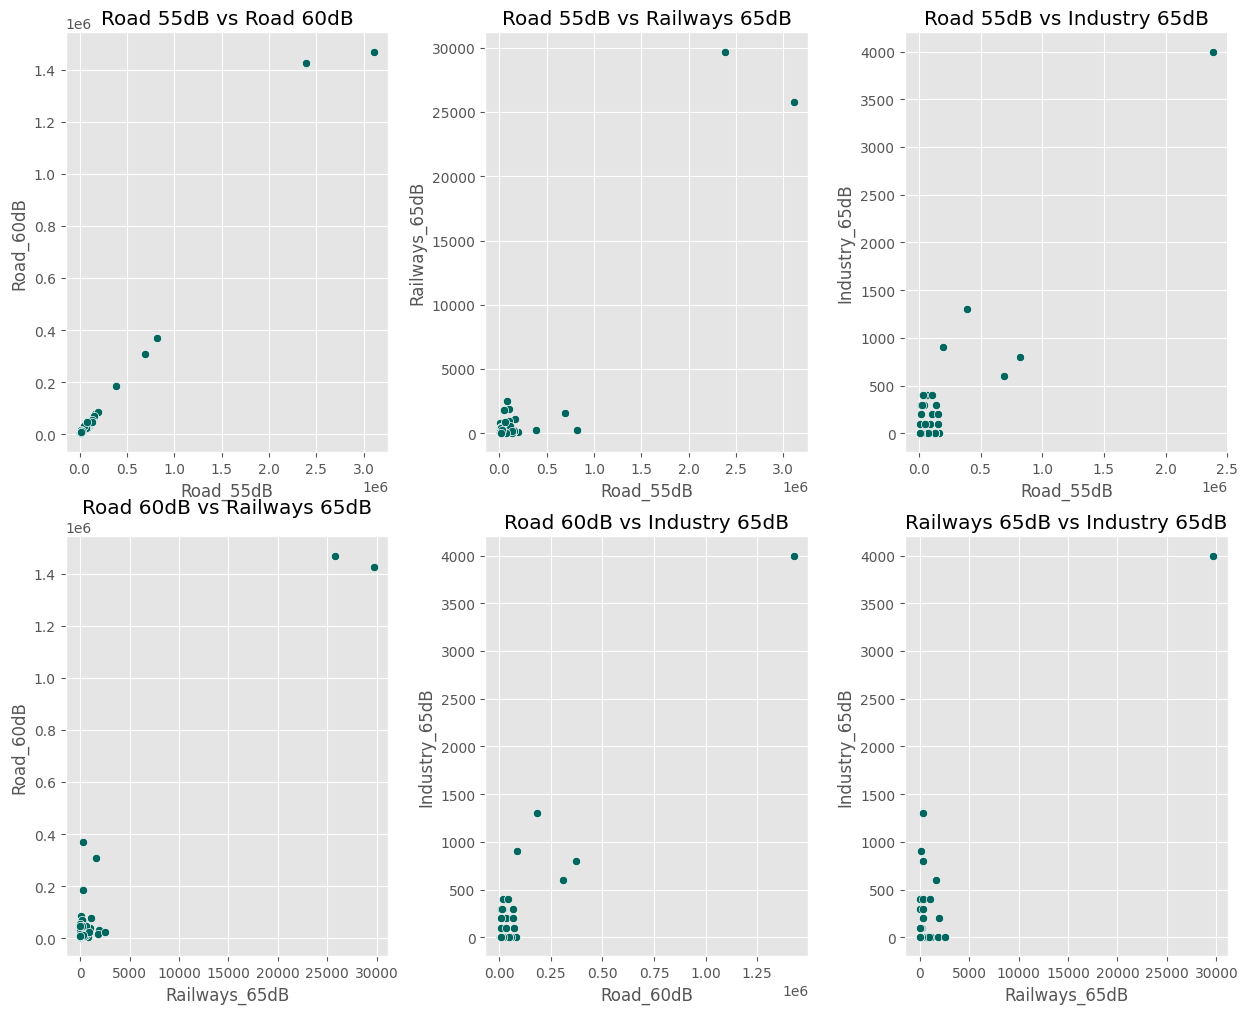

In [442]:
#Gráficos de dispersión entre las variables

fig, ax = plt.subplots(2, 3, figsize=(15, 12), gridspec_kw={'wspace':0.3})

sns.scatterplot(data = ruidoso, x = "Road_55dB", y = "Road_60dB" ,color = "#01665e", ax = ax[0,0])
ax[0,0].set_title("Road 55dB vs Road 60dB")

sns.scatterplot(data = ruidoso, x = "Road_55dB", y = "Railways_65dB" ,color = "#01665e", ax = ax[0,1])
ax[0,1].set_title("Road 55dB vs Railways 65dB")

sns.scatterplot(data = ruidoso, x = "Road_55dB", y = "Industry_65dB" ,color = "#01665e", ax = ax[0,2])
ax[0,2].set_title("Road 55dB vs Industry 65dB")

sns.scatterplot(data = ruidoso, x = "Railways_65dB", y = "Road_60dB" ,color = "#01665e", ax = ax[1,0])
ax[1,0].set_title("Road 60dB vs Railways 65dB")

sns.scatterplot(data = ruidoso, x = "Road_60dB", y = "Industry_65dB" ,color = "#01665e", ax = ax[1,1])
ax[1,1].set_title("Road 60dB vs Industry 65dB")

_ = sns.scatterplot(data = ruidoso, x = "Railways_65dB", y = "Industry_65dB" ,color = "#01665e", ax = ax[1,2])
ax[1,2].set_title("Railways 65dB vs Industry 65dB")

En el primer gráfico de dispersión se puede observar una posible relación lineal entre las variables "Road_55dB" y "Road_60dB", mientras que para el resto de gráficos a pesar de que aparentemente hay relación, no parecen ser concluyentes respecto a que tipo de relación se da entre las variables.


Para observar si estas relaciones son de tipo lineal realizamos la siguiente matriz de correlaciones:

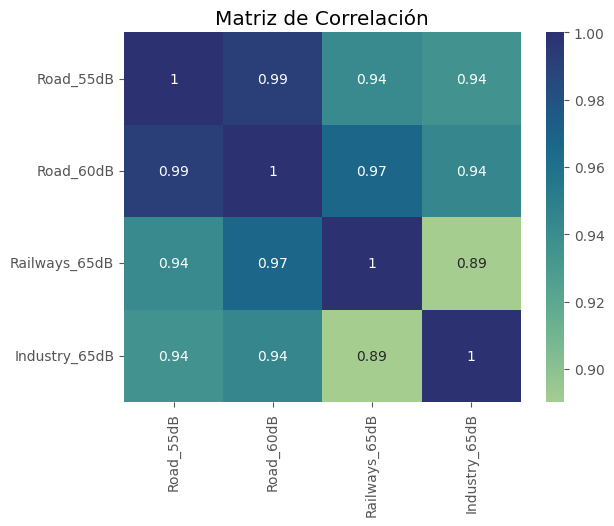

In [443]:
#Matriz de correlación
sns.heatmap(ruidoso.corr(), annot=True, cmap="crest")
plt.title("Matriz de Correlación")
plt.show()

Por medio de este gráfico confirmamos que debido a que los coeficientes de correlación están entre 0.8 y 1 entre las variables hay relaciones lineales positivas fuertes.

### **c.** Verifique si existen problemas de datos atípicos en cada una de las variables usando las metodologías de detección a nivel univariado.

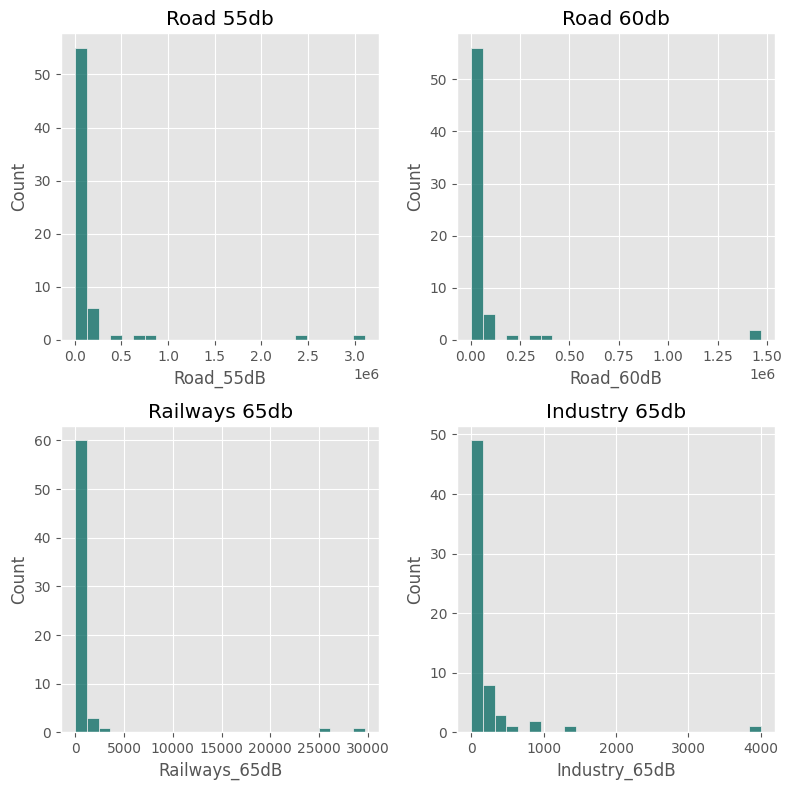

In [444]:
#Histogramas

fig, ax = plt.subplots(2,2, figsize = (8,8))


sns.histplot(ruidoso["Road_55dB"], color = "#01665e", bins = 25, ax = ax[0,0])
ax[0,0].set_title("Road 55db")

sns.histplot(ruidoso["Road_60dB"], color = "#01665e", bins = 25, ax = ax[0,1])
ax[0,1].set_title("Road 60db")

sns.histplot(ruidoso["Railways_65dB"], color = "#01665e", bins = 25, ax = ax[1,0])
ax[1,0].set_title("Railways 65db")

_ = sns.histplot(ruidoso["Industry_65dB"], color = "#01665e", bins = 25, ax = ax[1,1])
ax[1,1].set_title("Industry 65db")

plt.tight_layout()
plt.show()

Los histogramas nos muestran una tendencia hacía la izquierda de los datos en las tres variables, y también se pueden observar unos datos que se encuentran muy alejados de esta concentración, por lo tanto, podemos sospechar de posible presencia de datos atípicos.

#### Detección mediante boxplot

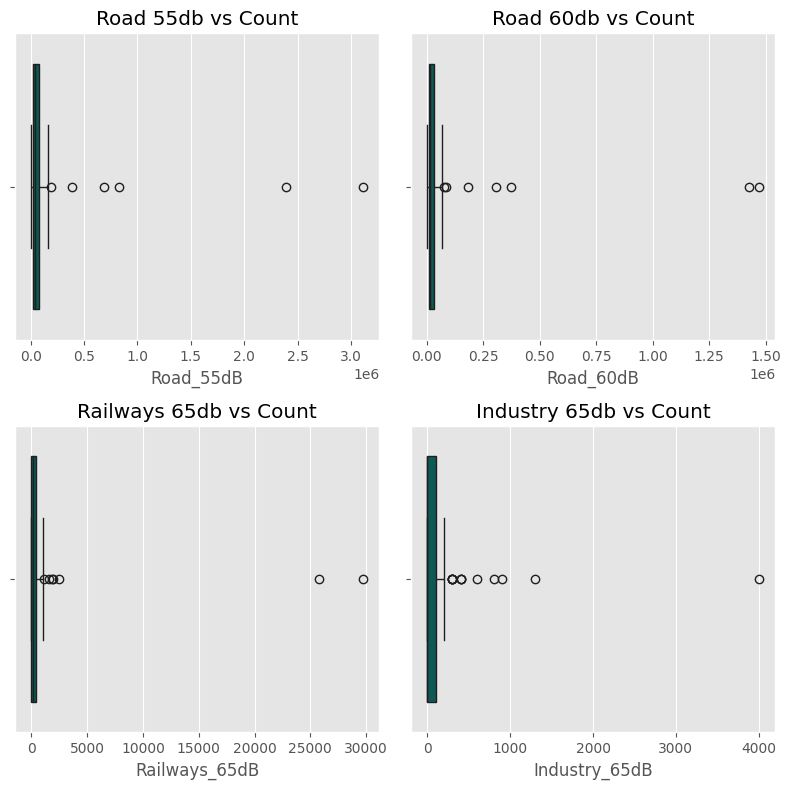

In [445]:
#Boxplots

fig, ax = plt.subplots(2,2, figsize = (8,8))


sns.boxplot(ruidoso["Road_55dB"], color = "#01665e", orient = "h", ax = ax[0,0])
ax[0,0].set_title("Road 55db vs Count")

sns.boxplot(ruidoso["Road_60dB"], color = "#01665e", orient = "h", ax = ax[0,1])
ax[0,1].set_title("Road 60db vs Count")

sns.boxplot(ruidoso["Railways_65dB"], color = "#01665e", orient = "h", ax = ax[1,0])
ax[1,0].set_title("Railways 65db vs Count")

_ = sns.boxplot(ruidoso["Industry_65dB"], color = "#01665e", orient = "h", ax = ax[1,1])
ax[1,1].set_title("Industry 65db vs Count")

plt.tight_layout()
plt.show()

Los boxplot nos indican la presencia de outliers para todas las variables, por lo cual confirmamos nuestras sospechas. El número de outliers parece ser alto en todos los casos, el primer boxplot es el que parece mostrar la menor cantidad de datos atípicos para "Road 55dB"

#### Detección mediante Z-score

Para continuar con el diagnóstico de outliers utilizamos el **Z-score**, y vamos a decir que aquellos que tengan un valor mayor a 3 en dicho cálculo serán considerados datos atípicos.

In [446]:
z_scores = zscore(ruidoso["Road_55dB"])
abs_z_scores = np.abs(z_scores)

outliers = ruidoso[abs_z_scores > 3]
outliers

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
48,2387200,1426100,29700,4000.00
65,3108200,1469100,25800,NaN


Según el diagnóstico de outliers Z-score, la columna 48 y 65 presentan datos atípicos.

#### Detección mediante Z-score modificado

Hacemos un proceso similar ahora con el **Z-score modificado**, ya que como vimos anteriormente en los histogramas los datos parecen ser asimétricos, por lo tanto, si utilizamos el **Z-score modificado** estaremos utilizando la mediana la cual es más robusta para este tipo de situaciones que la media. Establecemos un umbral de 3.5 para marcar como datos atípicos aquellos que superen dicho valor.

Consideramos un dato $x_i$ atípico si cumple con la siguiente condición:

$$
\frac{0.6745 \times (x_i - \text{Mediana})}{\text{MAD}} > \text{umbral},
$$

donde:

- $x_i$ es el valor del dato que estamos evaluando.
- $\text{Mediana}$ es el valor mediano de todo el conjunto de datos.
- $\text{MAD}$ representa la Desviación Absoluta Mediana.
- $\text{umbral}$ es un valor predefinido que determina el límite para considerar si un dato es atípico o no.

Si esta condición se cumple, entonces decimos que el dato $x_i$ es atípico. Esta metodología es especialmente útil en estadísticas robustas, proporcionando una manera eficaz de identificar valores atípicos en presencia de distribuciones no normales o cuando los datos contienen outliers significativos.

##### Columna Road 55dB

In [447]:
mad = MAD(threshold = 3.5)

total_reshaped = ruidoso["Road_55dB"].values.reshape(-1, 1)

labels = mad.fit(total_reshaped).labels_
labels

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [448]:
outliers = ruidoso[labels == 1]
outliers["Road_55dB"]

0      166400
7      388000
12     192900
14     823200
28     689300
48    2387200
65    3108200
Name: Road_55dB, dtype: int64

In [449]:
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 7


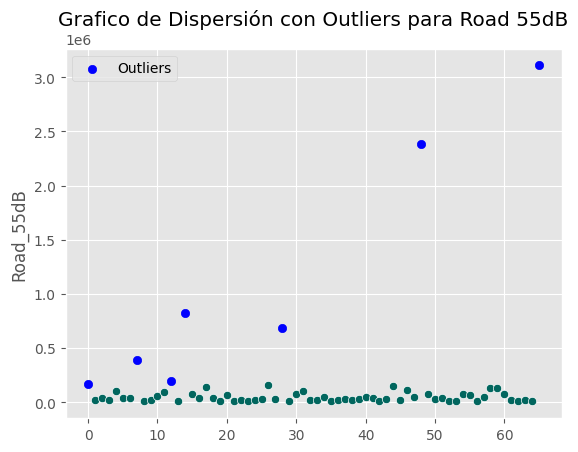

In [450]:
sns.scatterplot(data=ruidoso["Road_55dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Road_55dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Road 55dB")
_ = plt.legend()

##### Columna Road 60dB

In [451]:
ruidoso["Road_60dB"].tail()

61      16200
62       9900
63      12400
64       8500
65    1469100
Name: Road_60dB, dtype: int64

In [452]:
mad = MAD(threshold = 3.5)

total_reshaped = ruidoso["Road_60dB"].values.reshape(-1, 1)

labels = mad.fit(total_reshaped).labels_
labels

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [453]:
outliers = ruidoso[labels == 1]
outliers["Road_60dB"]

0       79200
7      185200
12      86000
14     371700
17      66200
26      67300
28     309300
44      69700
48    1426100
65    1469100
Name: Road_60dB, dtype: int64

In [454]:
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 10


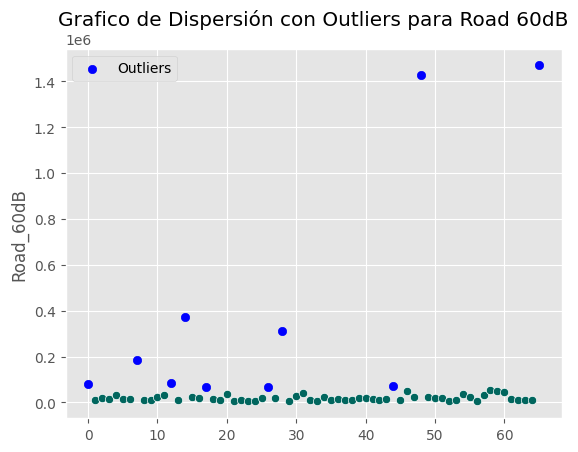

In [455]:
sns.scatterplot(data=ruidoso["Road_60dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Road_60dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Road 60dB")
_ = plt.legend()

##### Columna Railways 65dB

In [456]:
mad = MAD(threshold = 3.5)

total_reshaped = ruidoso["Railways_65dB"].values.reshape(-1, 1)

labels = mad.fit(total_reshaped).labels_
labels

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [457]:
outliers = ruidoso[labels == 1]
outliers["Railways_65dB"]

0      1100
4      1900
10      700
28     1600
29      800
31     1000
40     1800
48    29700
49     2500
55      900
65    25800
Name: Railways_65dB, dtype: int64

In [458]:
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 11


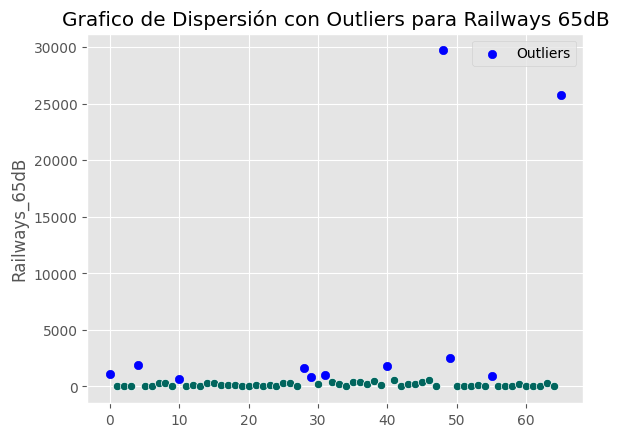

In [459]:
sns.scatterplot(data=ruidoso["Railways_65dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Railways_65dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Railways 65dB")
_ = plt.legend()

##### Columna Industry 65 dB

In [460]:
mad = MAD(threshold = 3.5)

total_reshaped = ruidoso["Industry_65dB"].values.reshape(-1, 1)

labels = mad.fit(total_reshaped).labels_
labels

/usr/local/lib/python3.10/dist-packages/pyod/models/mad.py:129: RuntimeWarning: divide by zero encountered in divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
/usr/local/lib/python3.10/dist-packages/pyod/models/mad.py:129: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.ravel(0.6745 * diff / self.median_diff_))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [461]:
outliers = ruidoso[labels == 1]
outliers["Industry_65dB"]

3     100.00
4     200.00
5     100.00
6     300.00
7    1300.00
8     200.00
9     100.00
11    100.00
12    900.00
14    800.00
17    300.00
18    300.00
19    300.00
20    400.00
25    400.00
26    200.00
28    600.00
31    400.00
37    100.00
44    100.00
48   4000.00
53    100.00
57    100.00
63    300.00
Name: Industry_65dB, dtype: float64

In [462]:
print(f'Number of outliers: {labels.sum()}')

Number of outliers: 24


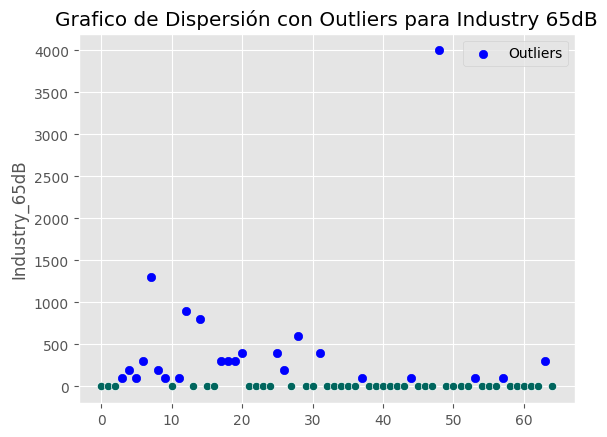

In [463]:
sns.scatterplot(data=ruidoso["Industry_65dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Industry_65dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Industry 65dB")
_ = plt.legend()

Por medio del Z-score modificado notamos una mayor cantidad de datos atípicos de los cuales algunos no fueron indentificados por medio del Z-score, esto puede ser debido a que la media y la desviación estándar de la muestra son sensibles cuando la distribución de los datos es asimétrica, mientras que la mediana es más robusta.

#### Detección mediante Rango Intercuartílico

##### Columna Road 55dB

Anteriormente habíamos graficado los boxplot, ahora utilizaremos los cálculos del **rango intercuartílico** para hallar los datos atípicos

In [464]:
seventy_fifth = ruidoso["Road_55dB"].quantile(0.75)
twenty_fifth = ruidoso["Road_55dB"].quantile(0.25)

iqr = seventy_fifth - twenty_fifth

upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

outliers = ruidoso[(ruidoso["Road_55dB"] < lower) | (ruidoso["Road_55dB"] > upper)]
outliers["Road_55dB"]

7      388000
12     192900
14     823200
28     689300
48    2387200
65    3108200
Name: Road_55dB, dtype: int64

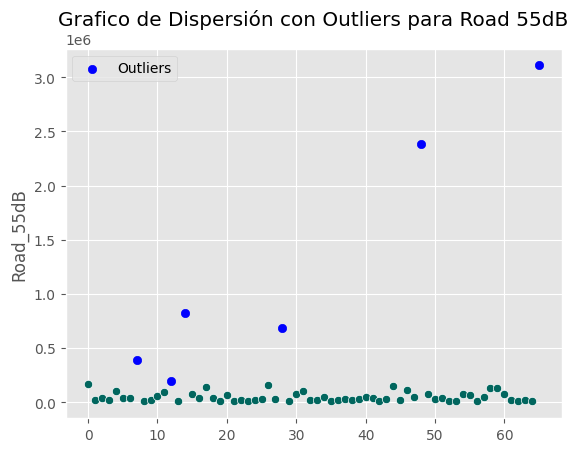

In [465]:
sns.scatterplot(data=ruidoso["Road_55dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Road_55dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Road 55dB")
_ = plt.legend()

In [466]:
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 6


##### Columna Railways 55dB

In [467]:
seventy_fifth = ruidoso["Railways_65dB"].quantile(0.75)
twenty_fifth = ruidoso["Railways_65dB"].quantile(0.25)

iqr = seventy_fifth - twenty_fifth

upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

outliers = ruidoso[(ruidoso["Railways_65dB"] < lower) | (ruidoso["Railways_65dB"] > upper)]
outliers["Railways_65dB"]

0      1100
4      1900
28     1600
40     1800
48    29700
49     2500
65    25800
Name: Railways_65dB, dtype: int64

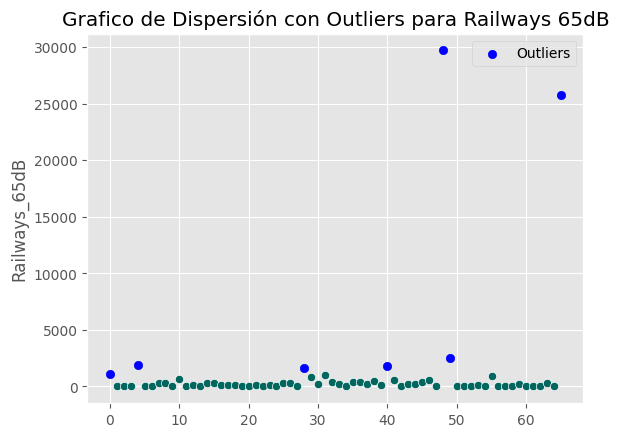

In [468]:
sns.scatterplot(data=ruidoso["Railways_65dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Railways_65dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Railways 65dB")
_ = plt.legend()

In [469]:
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 7


##### Columna Road 60dB

In [470]:
seventy_fifth = ruidoso["Road_60dB"].quantile(0.75)
twenty_fifth = ruidoso["Road_60dB"].quantile(0.25)

iqr = seventy_fifth - twenty_fifth

upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

outliers = ruidoso[(ruidoso["Road_60dB"] < lower) | (ruidoso["Road_60dB"] > upper)]
outliers["Road_60dB"]

0       79200
7      185200
12      86000
14     371700
28     309300
48    1426100
65    1469100
Name: Road_60dB, dtype: int64

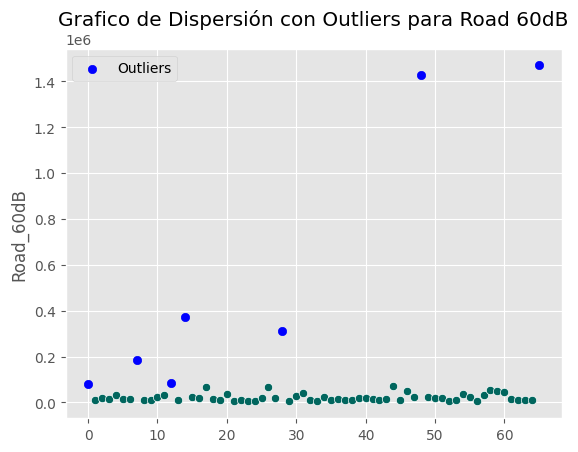

In [471]:
sns.scatterplot(data=ruidoso["Road_60dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Road_60dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Road 60dB")
_ = plt.legend()

In [472]:
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 7


##### Columna Industry 65dB

In [473]:
seventy_fifth = ruidoso["Industry_65dB"].quantile(0.75)
twenty_fifth = ruidoso["Industry_65dB"].quantile(0.25)

iqr = seventy_fifth - twenty_fifth

upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

outliers = ruidoso[(ruidoso["Industry_65dB"] < lower) | (ruidoso["Industry_65dB"] > upper)]
outliers["Industry_65dB"]

6     300.00
7    1300.00
12    900.00
14    800.00
17    300.00
18    300.00
19    300.00
20    400.00
25    400.00
28    600.00
31    400.00
48   4000.00
63    300.00
Name: Industry_65dB, dtype: float64

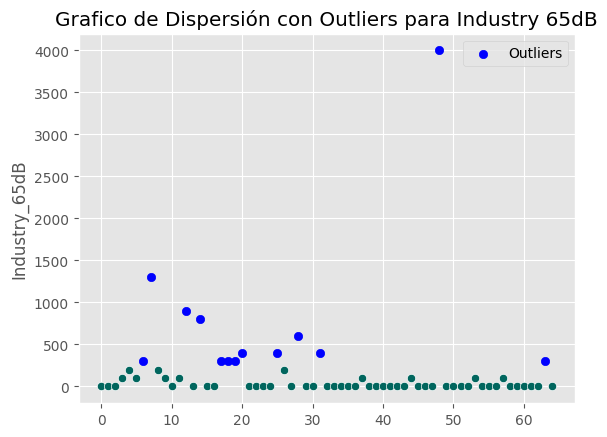

In [474]:
sns.scatterplot(data=ruidoso["Industry_65dB"], color="#01665e")
plt.scatter(outliers.index, outliers["Industry_65dB"], color="blue", label="Outliers")
plt.title("Grafico de Dispersión con Outliers para Industry 65dB")
_ = plt.legend()

In [475]:
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 13


Con el diagnóstico por medio del rango intercuantílico tenemos que coincide con los datos atípicos hallados por medio del Z-score modificado a excepción del dato con índice cero.

Notemos como dependiendo del método que utilizamos el criterior para declarar un dato como atípico o no va cambiando, en algunos casos obteníamos más datos atípicos que otros, y este se ve especialmente reflejado con las diferencias entre utilizar el **Z-Score** y el **Z-Score modificado** por lo que es importante conocer los datos con los que estamos trabajando, algo que muestra nuevamente la importancia de un análisis descriptivo inicial.

**d.** ¿Se detectan valores atípicos a nivel multivariado?


Realizaremos primero un análisis por medio de la **distancia de mahalanobis**, la cual es una medida de distancia entre el punto $\vec{x}=(x_1,x_2,x_3)$ y el vector de medias $\vec{\mu}=(\mu_1,\mu_2,\mu_3)$, teniendo en cuenta la matriz de varianzas y covarianzas $S$. La distancia de Mahalanobis se define como:

$$
D_{M}(\vec{x})=\sqrt{(\vec{x}-\vec{\mu})^TS^{-1}(\vec{x}-\vec{\mu})}
$$

In [476]:
#Realizamos una copia del data frame ruidoso
copia = ruidoso.copy()

#Ahora realizamos el proceso de hallas la distancia de mahalanobis sin tener en cuenta la presencia de un dato faltante
cov_matrix = np.cov(copia, rowvar=False)

cov_inv = np.linalg.inv(cov_matrix)

dist_mahalanobis = []
for row in copia.values:
    dist = distance.mahalanobis(row, copia.mean(), cov_inv)
    dist_mahalanobis.append(dist)

copia['mahalanobis_distance'] = dist_mahalanobis
print(copia)

    Road_55dB  Road_60dB  Railways_65dB  Industry_65dB  mahalanobis_distance
0      166400      79200           1100           0.00                   NaN
1       20000      11000              0           0.00                   NaN
2       37800      18000              0           0.00                   NaN
3       24500      16700              0         100.00                   NaN
4      103100      33500           1900         200.00                   NaN
..        ...        ...            ...            ...                   ...
61      20700      16200              0           0.00                   NaN
62      15100       9900              0           0.00                   NaN
63      24500      12400            300         300.00                   NaN
64      12800       8500              0           0.00                   NaN
65    3108200    1469100          25800            NaN                   NaN

[66 rows x 5 columns]


Como vemos, los datos faltantes parecen afectar el análisis multivariado de datos atípicos, por lo tanto, debemos tomar una decisión para poder solucionar dicho problema, para este caso decidimos imputar este único dato faltante presente en la columna "Industry_65dB" por medio de la media:

In [477]:
df = ruidoso.apply(lambda x: x.fillna(x.mean()), axis=0)

In [478]:
#Sabemos que el dato faltante estaba presente en la última fila de la columna Industry_65dB, observamos entonces la cola del data frame para confirmar
#la imputación realizada a este dato
df.tail()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
61,20700,16200,0,0.00
62,15100,9900,0,0.00
63,24500,12400,300,300.00
64,12800,8500,0,0.00
65,3108200,1469100,25800,180.00


Como ya hemos solucionado el problema del dato faltante, procedemos a realizar correctamente la detección de outliers multivariada por medio de la distancia de mahalanobis:

In [479]:
#Distancia de mahalanobis sin datos faltantes
cov_matrix = np.cov(df, rowvar=False)

cov_inv = np.linalg.inv(cov_matrix)

dist_mahalanobis = []
for row in df.values:
    dist = distance.mahalanobis(row, df.mean(), cov_inv)
    dist_mahalanobis.append(dist)

df["mahalanobis_distance"] = dist_mahalanobis

#Ordenamos las distancias de mayor a menor
df.sort_values(by="mahalanobis_distance", ascending = False)

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance
48,2387200,1426100,29700,4000.00,7.93
65,3108200,1469100,25800,180.00,7.76
14,823200,371700,300,800.00,5.38
7,388000,185200,300,1300.00,4.37
12,192900,86000,100,900.00,3.41
...,...,...,...,...,...
9,18600,12000,0,100.00,0.45
30,77400,26100,200,0.00,0.45
53,11600,8300,100,100.00,0.39
46,117200,48900,600,0.00,0.37


In [480]:
#Elegimos las primeras 10 filas que presentan una mayor distancia de mahalanobis
df.sort_values("mahalanobis_distance", ascending = False).head(10)

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance
48,2387200,1426100,29700,4000.00,7.93
65,3108200,1469100,25800,180.00,7.76
14,823200,371700,300,800.00,5.38
7,388000,185200,300,1300.00,4.37
12,192900,86000,100,900.00,3.41
28,689300,309300,1600,600.00,3.30
49,77200,24300,2500,0.00,3.17
4,103100,33500,1900,200.00,3.16
31,102800,41600,1000,400.00,2.29
40,47500,17400,1800,0.00,2.06


Realizaremos ahora un diagnóstico por medio de **Local Outlier Factor**, el cual es un método basado en densidad que utiliza la búsqueda de vecinos más cercanos. Este método calcula los scores para cada uno de los puntos a partir de la tasa promedio de densidad de los puntos vecinos con respecto a si mismo.


In [481]:
#Agregamos una columna con los respectivos Local Outlier Factor
lof = LocalOutlierFactor()
lof.fit_predict(df)

scores_lof = -lof.negative_outlier_factor_

df["lof_score"] = scores_lof

print(df)

    Road_55dB  Road_60dB  Railways_65dB  Industry_65dB  mahalanobis_distance  \
0      166400      79200           1100           0.00                  0.73   
1       20000      11000              0           0.00                  0.72   
2       37800      18000              0           0.00                  0.70   
3       24500      16700              0         100.00                  0.63   
4      103100      33500           1900         200.00                  3.16   
..        ...        ...            ...            ...                   ...   
61      20700      16200              0           0.00                  1.14   
62      15100       9900              0           0.00                  0.79   
63      24500      12400            300         300.00                  1.13   
64      12800       8500              0           0.00                  0.76   
65    3108200    1469100          25800         180.00                  7.76   

    lof_score  
0        2.21  
1      

Ordenamos de manera descendente por medio de la columna lof_score y analizamos los primeros 10 valores más altos:

In [482]:
df_sorted = df.sort_values(by="lof_score", ascending=False)
df_sorted.head(10)

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score
65,3108200,1469100,25800,180.00,7.76,42.56
48,2387200,1426100,29700,4000.00,7.93,34.70
14,823200,371700,300,800.00,5.38,12.33
28,689300,309300,1600,600.00,3.30,10.21
7,388000,185200,300,1300.00,4.37,5.87
12,192900,86000,100,900.00,3.41,2.57
0,166400,79200,1100,0.00,0.73,2.21
26,156000,67300,300,200.00,0.61,2.02
44,152500,69700,200,100.00,0.86,2.00
17,140900,66200,100,300.00,0.79,1.87


Finalizamos los diagósticos de datos atípicos de manera multivariado por medio del **Isolation Forest**,el cual aisla datos anómalos de los datos normales mediante la partición recursiva del conjunto de datos.

In [483]:
n_arboles = 250

isolation_forest = IsolationForest(n_estimators=n_arboles, random_state=42)
puntajes_anomalia = isolation_forest.fit(df)

puntajes_anomalia = isolation_forest.score_samples(df)

puntajes_anomalia = -puntajes_anomalia


df["puntajes_anomalia"] = puntajes_anomalia

Ordenamos de manera descendente la columna "puntajes_anomalia" y analizamos las primeras 4 filas:

In [484]:
df_sorted = df.sort_values(by="puntajes_anomalia", ascending=False)
df_sorted.head(4)

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB,mahalanobis_distance,lof_score,puntajes_anomalia
48,2387200,1426100,29700,4000.00,7.93,34.70,0.82
65,3108200,1469100,25800,180.00,7.76,42.56,0.81
14,823200,371700,300,800.00,5.38,12.33,0.69
28,689300,309300,1600,600.00,3.30,10.21,0.67


Por medio de scatter plots en 3D podemos visualizar los datos atípicos encontrados (en este caso tomaremos como datos atípicos los 5 primeros datos con mayor distancia de mahalanobis) de manera trivariada de la siguiente forma:



*   **Road_55dB vs Road_60dB vs Railways_65dB**




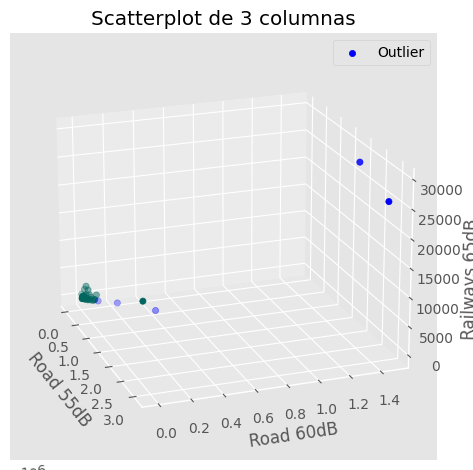

In [485]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

outliers_indices = df.sort_values(by="mahalanobis_distance", ascending=False).head().index

mask_no_outliers = ~ruidoso.index.isin(outliers_indices)
ax.scatter(ruidoso.loc[mask_no_outliers, "Road_55dB"],
           ruidoso.loc[mask_no_outliers, "Road_60dB"],
           ruidoso.loc[mask_no_outliers, "Railways_65dB"],
           c="#01665e")

ax.scatter(ruidoso.loc[outliers_indices, "Road_55dB"],
           ruidoso.loc[outliers_indices, "Road_60dB"],
           ruidoso.loc[outliers_indices, "Railways_65dB"],
           c="blue", label='Outlier')

ax.set_xlabel("Road 55dB")
ax.set_ylabel("Road 60dB")
ax.set_zlabel("Railways 65dB")
ax.set_title('Scatterplot de 3 columnas')

ax.legend()

ax.view_init(elev=20, azim=-20)
plt.tight_layout()
plt.show()



*   **Road_55dB vs Road_60dB vs Industry_65dB**



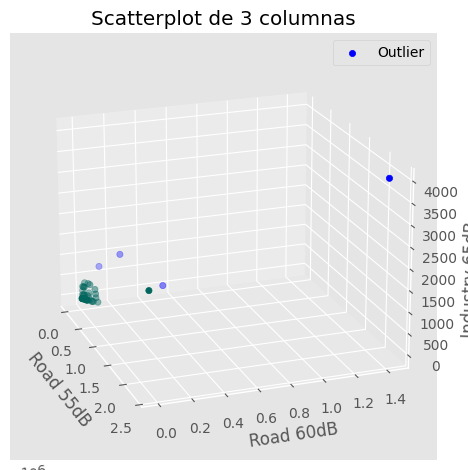

In [486]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

outliers_indices = df.sort_values(by="mahalanobis_distance", ascending=False).head().index

mask_no_outliers = ~ruidoso.index.isin(outliers_indices)
ax.scatter(ruidoso.loc[mask_no_outliers, "Road_55dB"],
           ruidoso.loc[mask_no_outliers, "Road_60dB"],
           ruidoso.loc[mask_no_outliers, "Industry_65dB"],
           c="#01665e")

ax.scatter(ruidoso.loc[outliers_indices, "Road_55dB"],
           ruidoso.loc[outliers_indices, "Road_60dB"],
           ruidoso.loc[outliers_indices, "Industry_65dB"],
           c="blue", label='Outlier')

ax.set_xlabel("Road 55dB")
ax.set_ylabel("Road 60dB")
ax.set_zlabel("Industry 65dB")
ax.set_title('Scatterplot de 3 columnas')

ax.legend()

ax.view_init(elev=20, azim=-20)
plt.tight_layout()
plt.show()



*   **Road_55dB vs Railways_65dB vs Industry_65dB**



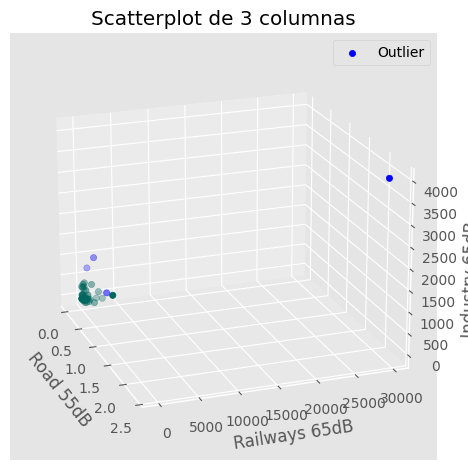

In [487]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

outliers_indices = df.sort_values(by="mahalanobis_distance", ascending=False).head().index

mask_no_outliers = ~ruidoso.index.isin(outliers_indices)
ax.scatter(ruidoso.loc[mask_no_outliers, "Road_55dB"],
           ruidoso.loc[mask_no_outliers, "Railways_65dB"],
           ruidoso.loc[mask_no_outliers, "Industry_65dB"],
           c="#01665e")

ax.scatter(ruidoso.loc[outliers_indices, "Road_55dB"],
           ruidoso.loc[outliers_indices, "Railways_65dB"],
           ruidoso.loc[outliers_indices, "Industry_65dB"],
           c="blue", label='Outlier')

ax.set_xlabel("Road 55dB")
ax.set_ylabel("Railways 65dB")
ax.set_zlabel("Industry 65dB")
ax.set_title('Scatterplot de 3 columnas')

ax.legend()

ax.view_init(elev=20, azim=-20)
plt.tight_layout()
plt.show()



*   **Road_60dB vs Railways_65dB vs Industry_65dB**



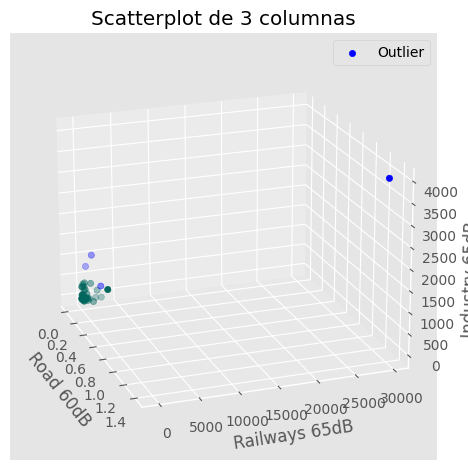

In [488]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

outliers_indices = df.sort_values(by="mahalanobis_distance", ascending=False).head().index

mask_no_outliers = ~ruidoso.index.isin(outliers_indices)
ax.scatter(ruidoso.loc[mask_no_outliers, "Road_60dB"],
           ruidoso.loc[mask_no_outliers, "Railways_65dB"],
           ruidoso.loc[mask_no_outliers, "Industry_65dB"],
           c="#01665e")

ax.scatter(ruidoso.loc[outliers_indices, "Road_60dB"],
           ruidoso.loc[outliers_indices, "Railways_65dB"],
           ruidoso.loc[outliers_indices, "Industry_65dB"],
           c="blue", label='Outlier')

ax.set_xlabel("Road 60dB")
ax.set_ylabel("Railways 65dB")
ax.set_zlabel("Industry 65dB")
ax.set_title('Scatterplot de 3 columnas')

ax.legend()

ax.view_init(elev=20, azim=-20)
plt.tight_layout()
plt.show()

**e.** Para el caso univariado, escoja una variable y realice un análisis sobre las
implicaciones que tiene realizar diferentes tratamientos a los datos atípicos en la distribución de la respectiva variable.


Elegimos la variable "Road_60dB" para el análisis de las implicaciones que presentan realizar los siguientes tratamientos a los datos atípicos:

*   Distribución original




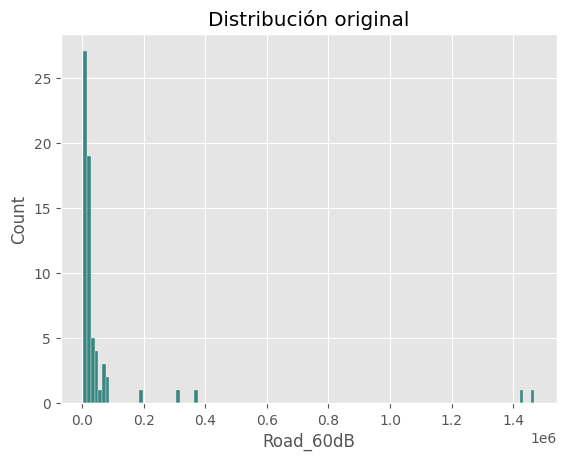

In [489]:
graf1 = sns.histplot(ruidoso["Road_60dB"], color = "#01665e").set_title("Distribución original")

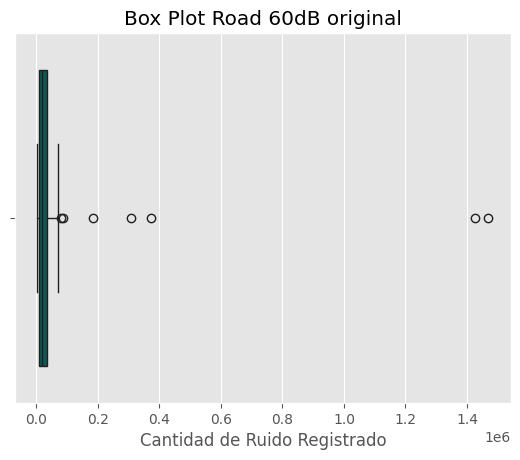

In [490]:
g = sns.boxplot(data = ruidoso, x = "Road_60dB", color = "#01665e")

g.set_title("Box Plot Road 60dB original")
_ = g.set_xlabel("Cantidad de Ruido Registrado")

*   Eliminar datos atípicos:

In [491]:
#el criterio que utilizaremos será el del rango intercuartílico

seventy_fifth = ruidoso["Road_60dB"].quantile(0.75)
twenty_fifth = ruidoso["Road_60dB"].quantile(0.25)

iqr = seventy_fifth - twenty_fifth

upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

outliers = ruidoso[(ruidoso["Road_60dB"] < lower) | (ruidoso["Road_60dB"] > upper)]

In [492]:
#data frame sin atípicos

no_atipicos = ruidoso.copy()
no_atipicos = no_atipicos.drop(outliers.index)

Realizamos entonces un histograma para poder observar como eliminar los datos atípicos afecta la distribución de los datos en la variable "Road_60dB"

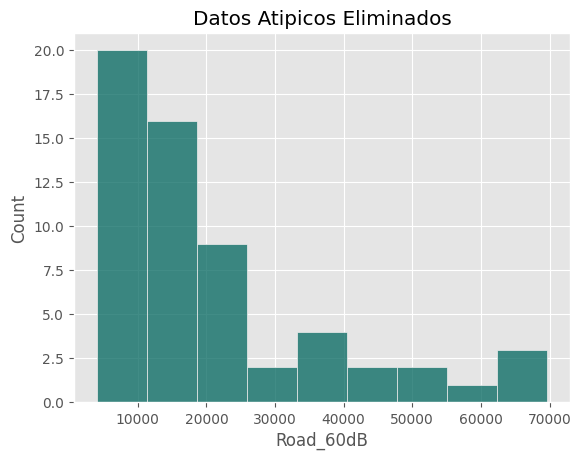

In [493]:
graf1 = sns.histplot(no_atipicos["Road_60dB"], color = "#01665e").set_title("Datos Atipicos Eliminados")

A pesar de que hay mejoría en la distribución de los datos ya que no se observan valores tan extremos, no tenemos seguridad de que los datos atípicos provengan de un error en la entrada de los mismos o de un error humano, por lo tanto, eliminarlos no es adecuado, además podríamos perder información que puede ser de gran relevancia dentro de nuestro análisis.



*   Imputar a través de la mediana:

Reemplazamos los valores atípicos de la variable "Road_60dB" por la media de dicha columna de datos.

In [494]:
median_value = ruidoso["Road_60dB"].median()

imputado_mediana = ruidoso.copy()
imputado_mediana.loc[outliers.index, "Road_60dB"] = median_value

Realizamos entonces un histograma para ver la distribución de los datos de dicha variable luego de la imputación.

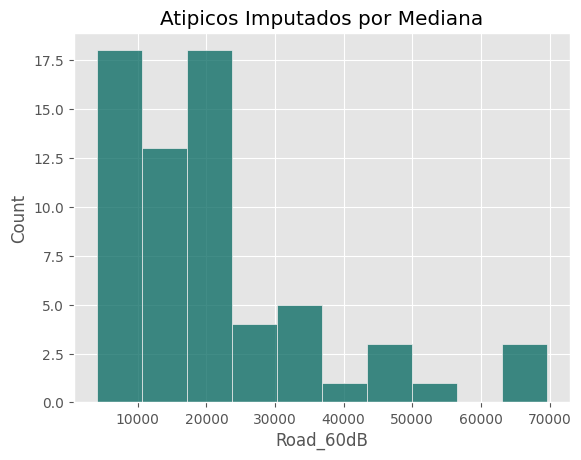

In [495]:
_ = sns.histplot(imputado_mediana["Road_60dB"], color = "#01665e").set_title("Atipicos Imputados por Mediana")

Imputar por mediana también presenta una mejoría respecto a la distribución original, en el sentido de que ya no vemos datos tan alejados como en el histograma original (aunque en menor medida que cuando eliminamos los datos atípicos). Sin embargo, nuevamente debemos tener en cuenta que eliminar los datos atípicos sin tener un motivo de fuerza mayor (errores de escritura por ejemplo) no es algo que se deba realizar


In [496]:
mean_value = ruidoso["Road_60dB"].mean()

imputado_media = ruidoso.copy()
imputado_media.loc[outliers.index, "Road_60dB"] = mean_value

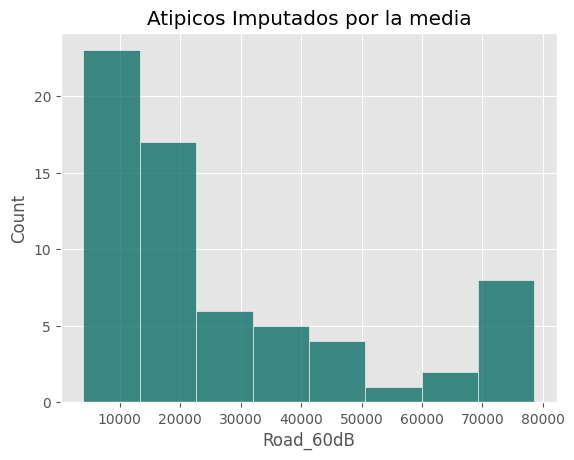

In [497]:
_ = sns.histplot(imputado_media["Road_60dB"], color = "#01665e").set_title("Atipicos Imputados por la media")

*   Winzorizar:

Reemplazamos los valores atípicos por el valor más cercano que no se considera un outlier según ciertos criterios.



In [498]:
winsorized = ruidoso.copy()
winsorized["Road_60dB"] = winsorize(winsorized["Road_60dB"],\
limits = [0.05, 0.05], inplace = True)

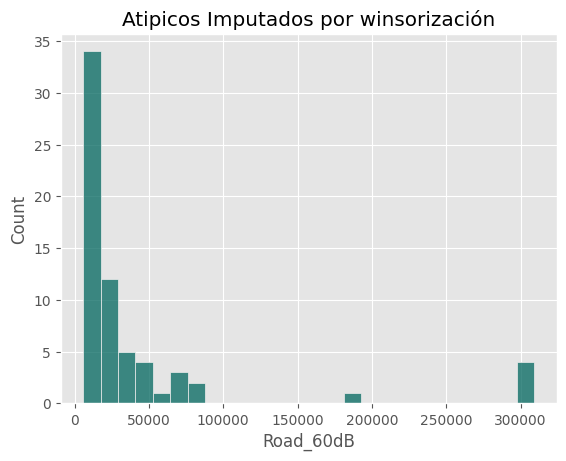

In [499]:
_ = sns.histplot(winsorized["Road_60dB"], color = "#01665e").set_title("Atipicos Imputados por winsorización")

Analizamos los respectivos boxplot de cada uno de los métodos anteriormente utilizados para ver los resultados

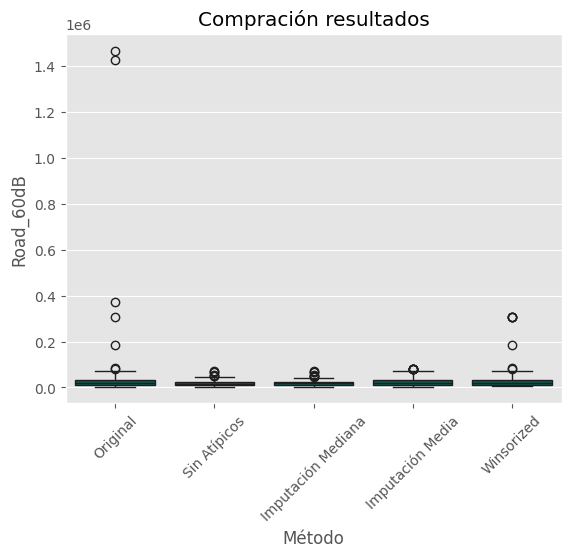

In [500]:
datos = pd.DataFrame({
    "Original": ruidoso["Road_60dB"],
    "Sin Atípicos": no_atipicos["Road_60dB"],
    "Imputación Mediana": imputado_mediana["Road_60dB"],
    "Imputación Media": imputado_media["Road_60dB"],
    "Winsorized": winsorized["Road_60dB"]
})

datos_melt = datos.melt(var_name="Método", value_name="Road_60dB")

sns.boxplot(x="Método", y="Road_60dB", data=datos_melt, color = "#01665e")

plt.title("Compración resultados")
plt.xticks(rotation=45)

plt.show()

Es posible ver en todos los boxplot una reducción en la cantidad de datos atípicos comparado con la distribución original. Sin embargo, esto no significa que los datos sean mejores o de mayor calidad, por el contrario puede que estemos perdiendo datos que reflejan posibles situaciones que al momento de hacer un modelo o algún procedimiento más elaborda se deben de tener en cuenta

# Punto 2

A partir del dataset auto-mpg.data-original.txt (https://archive.ics.uci.edu/dataset/9/auto+mpg) realice los siguientes análisis:


**a.** Cargue y explore el dataset explicando en qué consiste y las características que posee el mismo.

In [501]:
datos = pd.read_csv('auto-mpg.data-original.txt',sep="\s+", header= 0,  names=["mpg","cylinders","displacement",
                                                                               "horsepower", "weight", "acceleration",
                                                                               "model year", "origin", "car name"])

In [502]:
#Hacemos un análisis exploratorio inicial del data frma por medio del encabezado y cola de los datos:
print(f"Encabezado de la base de datos:\n{datos.head()}\n")
print(f"Cola de la base de datos:\n{datos.tail()}")

Encabezado de la base de datos:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0 15.00       8.00        350.00      165.00 3693.00         11.50   
1 18.00       8.00        318.00      150.00 3436.00         11.00   
2 16.00       8.00        304.00      150.00 3433.00         12.00   
3 17.00       8.00        302.00      140.00 3449.00         10.50   
4 15.00       8.00        429.00      198.00 4341.00         10.00   

   model year  origin            car name  
0       70.00    1.00   buick skylark 320  
1       70.00    1.00  plymouth satellite  
2       70.00    1.00       amc rebel sst  
3       70.00    1.00         ford torino  
4       70.00    1.00    ford galaxie 500  

Cola de la base de datos:
      mpg  cylinders  displacement  horsepower  weight  acceleration  \
400 27.00       4.00        140.00       86.00 2790.00         15.60   
401 44.00       4.00         97.00       52.00 2130.00         24.60   
402 32.00       4.00        135.00      

Las columnas que vemos en el dataset y su significado son el siguiente



*   mpg: Millas que puede conducir un carro por cada galón de gasolina

*   cylinders: Es la cantidad de cilindros que tiene el motor de un carro

*   displacement: Volumen que ocupan los motores

* horsepower: Medida de que tan rápido se produce la fuerza de un motor

* weight: Peso del carro

* Aceleración: Tasa de cambio de la velocidad

* model year: Año en que fue fabricado el carro

* origin: Lugar en el que fue manufacturado el carro (1:USA, 2:Europa, 3:Asia)



In [503]:
#Tamaño del data frame
print(f"El tamaño del dataframe es de {datos.shape}")

El tamaño del dataframe es de (405, 9)


In [504]:
#Tipo de variables dentro del data frame
datos.dtypes

mpg             float64
cylinders       float64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year      float64
origin          float64
car name         object
dtype: object

Como podemos observar, hay presencia de 8 variables de tipo float, es decir con parte decimale y solo una categórica, sin embargo, al analizar la naturaleza de variables como "origin","cylinders" y "model year" estas aparentemente son de tipo ordinal.

In [505]:
#Cantidad de datos faltantes
datos.isna().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Unicamente las variables "mpg" y "horsepower" tienen presencia de datos faltantes con un total de 8 y 6, respectivamente.

**b.** Realice un breve análisis exploratorio para identificar la distribución de las variables usadas en la base de datos ¿será que existe relación entre las variables?

In [506]:
datos.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,397.00,405.00,405.00,399.00,405.00,405.00,405.00,405.00
mean,23.53,5.47,194.50,105.02,2978.12,15.53,75.94,1.57
std,7.82,1.71,104.90,38.80,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,105.00,75.50,2226.00,13.70,73.00,1.00
50%,23.00,4.00,151.00,95.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.50,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00




*   **Histogramas de las variables numéricas presentes en el data frame:**






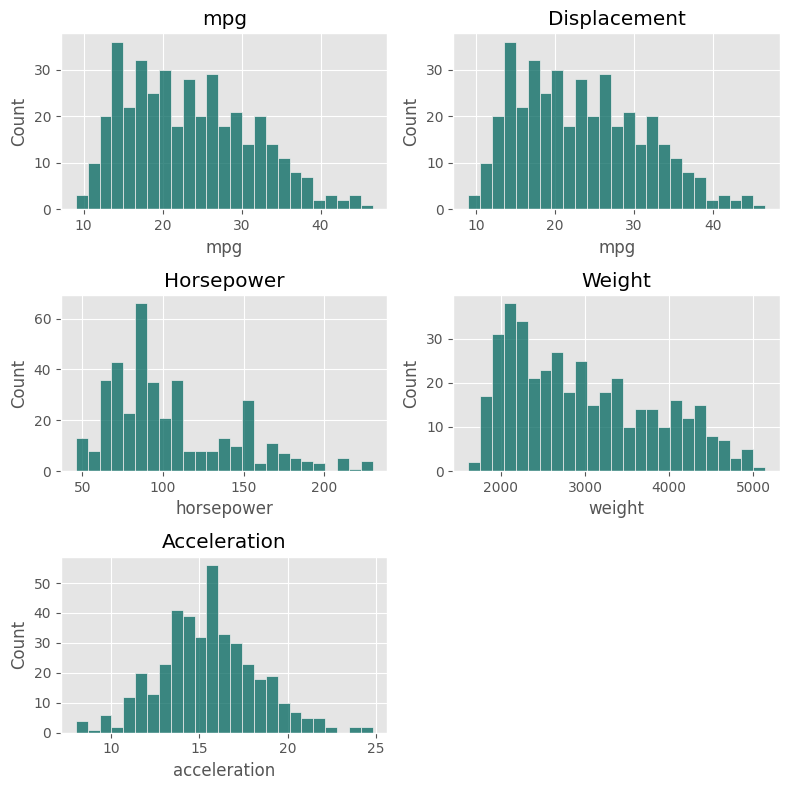

In [507]:
fig, ax = plt.subplots(3, 2, figsize=(8, 8))

fig.delaxes(ax[2, 1])

sns.histplot(datos["mpg"], color="#01665e", bins=25, ax=ax[0, 0])
ax[0, 0].set_title("mpg")

sns.histplot(datos["mpg"], color="#01665e", bins=25, ax=ax[0, 1])
ax[0, 1].set_title("Displacement")

sns.histplot(datos["horsepower"], color="#01665e", bins=25, ax=ax[1, 0])
ax[1, 0].set_title("Horsepower")

sns.histplot(datos["weight"], color="#01665e", bins=25, ax=ax[1, 1])
ax[1, 1].set_title("Weight")

sns.histplot(datos["acceleration"], color="#01665e", bins=25, ax=ax[2, 0])
ax[2, 0].set_title("Acceleration")

plt.tight_layout()
plt.show()

Las variables parecen presentar distribuciones asimétricas excepto "acceleration", la cual aparentemente tiene una distribución aproximadamente simétrica.



*   **Gráficos de conteos:**


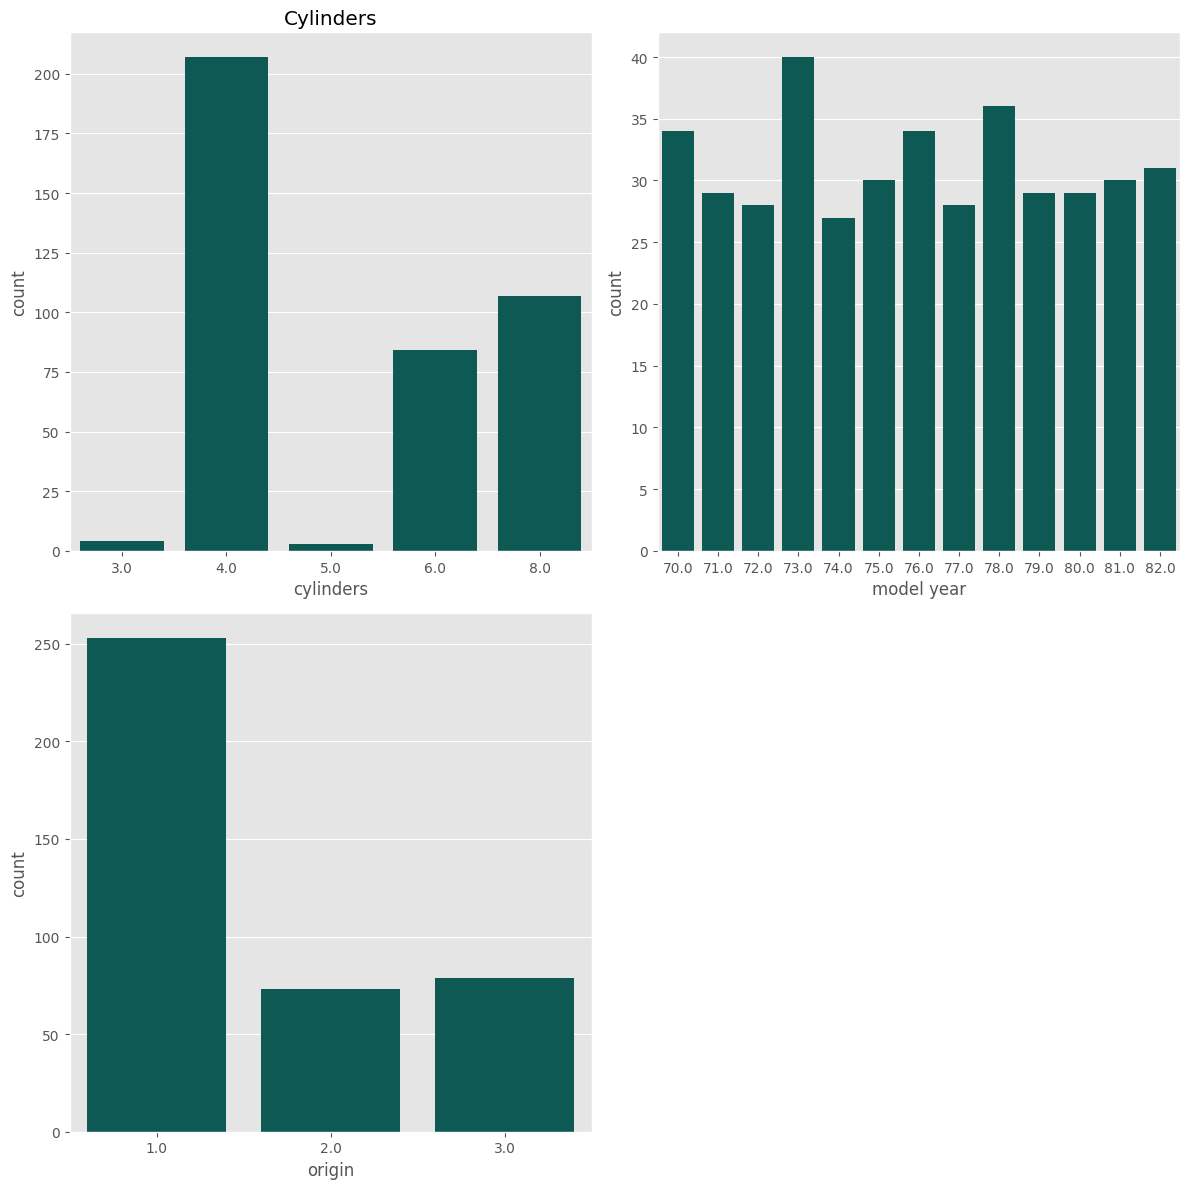

In [508]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

fig.delaxes(ax[1, 1])

sns.countplot(x = "cylinders", data = datos, color="#01665e", ax=ax[0, 0])
ax[0, 0].set_title("Cylinders")

sns.countplot(x = "model year", data = datos, color="#01665e", ax=ax[0, 1])
ax[0, 0].set_title("Cylinders")

sns.countplot(x = "origin", data = datos, color="#01665e", ax=ax[1, 0])
ax[0, 0].set_title("Cylinders")

plt.tight_layout()
plt.show()

Para las variables categóricas los gráficos de barras anteriores nos muestran todos los posibles valores que toman estas variables y cuales son los valores más repetidos en nuestro dataset



*   **Gráficos de dispersión:**



Text(0.5, 1.0, 'Acceleration vs Weight')

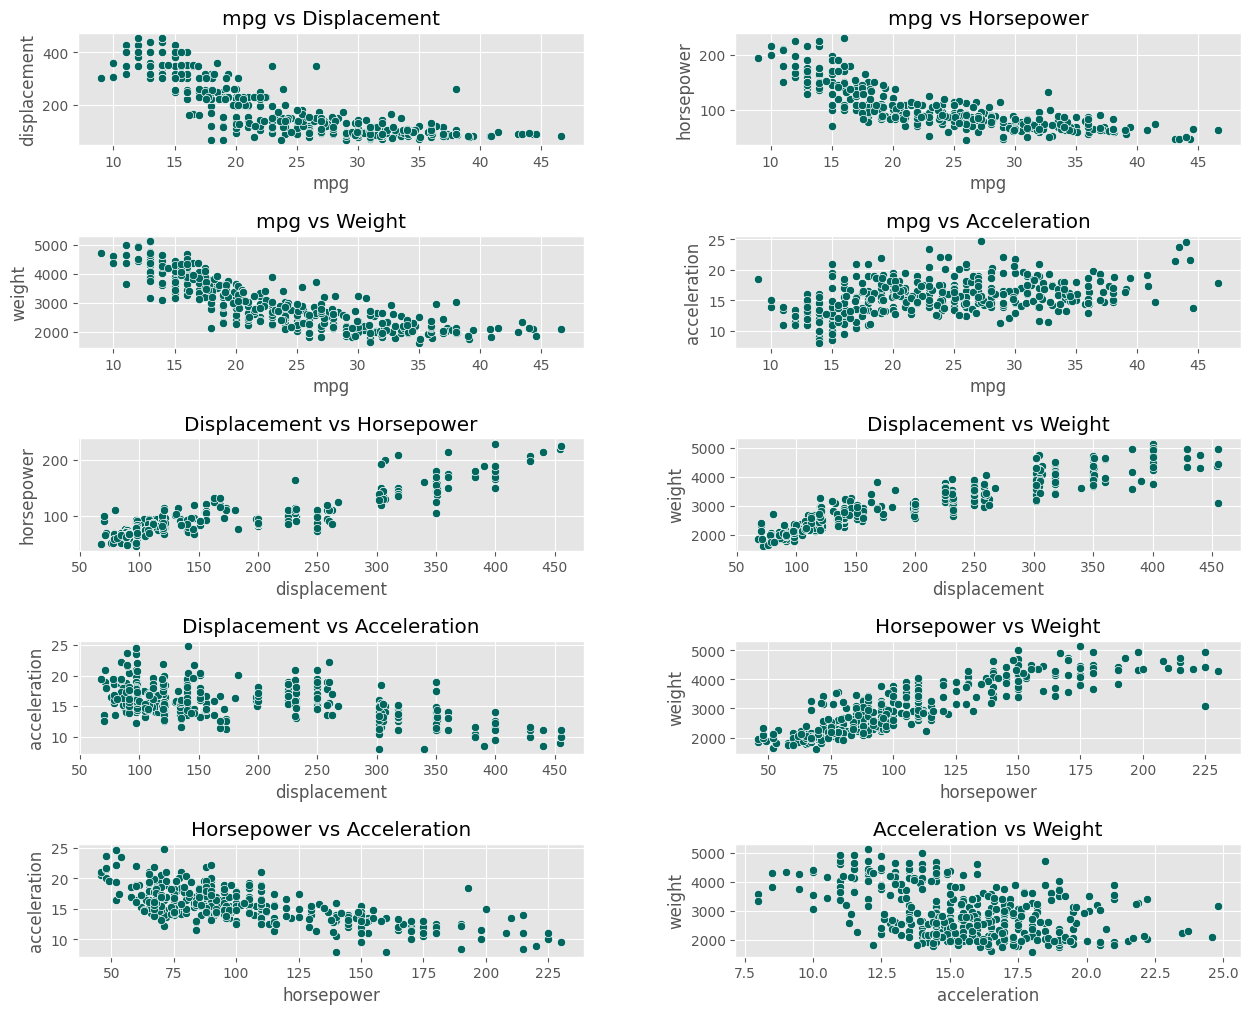

In [509]:
fig, ax = plt.subplots(5, 2, figsize=(15, 12), gridspec_kw={'wspace':0.3, "hspace":0.8})

sns.scatterplot(data = datos, x = "mpg", y = "displacement" ,color = "#01665e", ax = ax[0,0])
ax[0,0].set_title("mpg vs Displacement")

sns.scatterplot(data = datos, x = "mpg", y = "horsepower" ,color = "#01665e", ax = ax[0,1])
ax[0,1].set_title("mpg vs Horsepower")

sns.scatterplot(data = datos, x = "mpg", y = "weight" ,color = "#01665e", ax = ax[1,0])
ax[1,0].set_title("mpg vs Weight")

sns.scatterplot(data = datos, x = "mpg", y = "acceleration" ,color = "#01665e", ax = ax[1,1])
ax[1,1].set_title("mpg vs Acceleration")

sns.scatterplot(data = datos, x = "displacement", y = "horsepower" ,color = "#01665e", ax = ax[2,0])
ax[2,0].set_title("Displacement vs Horsepower")

sns.scatterplot(data = datos, x = "displacement", y = "weight" ,color = "#01665e", ax = ax[2,1])
ax[2,1].set_title("Displacement vs Weight")

sns.scatterplot(data = datos, x = "displacement", y = "acceleration" ,color = "#01665e", ax = ax[3,0])
ax[3,0].set_title("Displacement vs Acceleration")

sns.scatterplot(data = datos, x = "horsepower", y = "weight" ,color = "#01665e", ax = ax[3,1])
ax[3,1].set_title("Horsepower vs Weight")

sns.scatterplot(data = datos, x = "horsepower", y = "acceleration" ,color = "#01665e", ax = ax[4,0])
ax[4,0].set_title("Horsepower vs Acceleration")

sns.scatterplot(data = datos, x = "acceleration", y = "weight" ,color = "#01665e", ax = ax[4,1])
ax[4,1].set_title("Acceleration vs Weight")

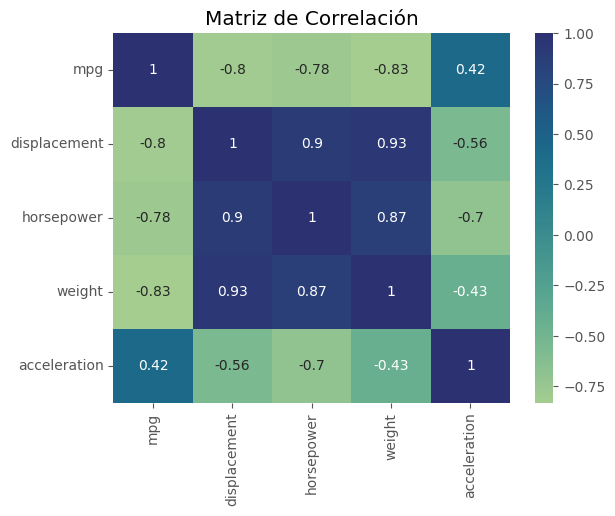

In [510]:
correlaciones = datos[["mpg", "displacement", "horsepower", "weight", "acceleration"]]
sns.heatmap(correlaciones.corr(), annot=True, cmap="crest")
plt.title("Matriz de Correlación")
plt.show()

Para los coeficientes de relación de las variables tenemos que:



$$ 0 < ρ < 0.6$$ acceleration y mpg tienen una relación lineal positiva débil
<br/>

$$ 0.6 \leq ρ < 0.8$$ ninguna variable tienen una relación lineal positiva moderada
<br/>

$$ 0.8 \leq ρ \leq 1$$ horsepower y displacement, weight y horsepower, weight y displacement, tienen una relación lineal positiva fuerte
<br/>

$$ -0.6 \leq \rho \leq 0  $$ acceleration y weight, acceleration y displacement, tienen una relación lineal negativa débil
<br/>

$$ -0.8 \leq \rho \leq -0.6  $$ displacement y mpg, horsepower y mpg, acceleration y horsepower,  tienen una relación lineal negativa moderada
<br/>

$$ -1 \leq \rho \leq -0.8  $$ weight y mpg tienen una relación lineal negativa fuerte
<br/>



**c.** Verifique si existen datos faltantes en cada uno de las variables. ¿Cuál es la proporción de datos faltantes en la distribución de las variables?

In [511]:
#Cantidad de datos faltantes
datos.isna().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [512]:
#Proporción de datos faltantes
proporcion_mpg = 8/len(datos["mpg"])
proporcion_horsepower = 6/len(datos["horsepower"])

print(f"Proporción de mpg: {proporcion_mpg} \nProporción de horsepower: {proporcion_horsepower}")

Proporción de mpg: 0.019753086419753086 
Proporción de horsepower: 0.014814814814814815


**d.** ¿Cuál cree que es el mecanismo inherente a esos datos faltantes?

El mecanismo de datos faltantes para este caso es **Missing completely at random MCAR** ya que la pérdida de estos datos no tiene relación con las características observadas y no observadas.

**e.** Aplique las técnicas de tratamiento de datos faltantes vistas en clase.



*   **Eliminación de filas:**



La eliminación de datos faltantes es una opción razonable en escenarios donde tenemos muchos datos y admeás la proporción de datos faltantes no es muy grande, como vimos anteriormente, la proporción de datos faltantes no es muy grande, sin embargo, sería ideal contar con una mayor cantidad de datos para realizar este proceso.

In [513]:
#Eliminación de filas con datos faltantes
tratamiento1 = datos.copy()
tratamiento1.dropna(subset=["mpg", "horsepower"], how = "any",inplace=True)



*   **Imputación con una constante:**



Si eliminar los datos no es una buena idea es posible imputar todo bajo el mismo valor, en este caso lo haremos utilizando 0 como nuestro valor.

In [514]:
#imputación utilizando 0 como constante
tratamiento2 = datos.copy()
mean_imputer = SimpleImputer(missing_values=np.nan, strategy = "constant", fill_value=0)
tratamiento2.iloc[:,:] = mean_imputer.fit_transform(tratamiento2)



*   **Imputación usando la moda:**




También es posible imputar una constante pero que siga una regla más específica, por ejemplo, en el caso de la moda es el valor que más se repite dentro de cada columna.

In [515]:
#Imputación utilizando la moda
tratamiento3 = datos.copy()
mean_imputer = SimpleImputer(strategy = "most_frequent")

tratamiento3.iloc[:,:] = mean_imputer.fit_transform(tratamiento3)

*   **Imputación usando Hot Deck:**

Imputación modelando una característica con datos faltantes como una función de las otras,
de tal forma que el reemplazo de los datos faltantes se hace con un valor que tiene valores similares en las otras características

In [516]:
tratamiento4=datos.copy()
tratamiento4_numeric = tratamiento4.select_dtypes(include = "number")

imputer = IterativeImputer(imputation_order = "ascending")
imputed = imputer.fit_transform(tratamiento4_numeric)
tratamiento4 = pd.DataFrame(imputed, columns=tratamiento4_numeric.columns)

*   **Imputación usando KNN:**

En este caso utilizando el algoritmo KNN la imputación se realiza utilizando las características de los puntos no atípicos más cercanos al dato faltante pudiendo definir cuantos puntos cercanos o "vecinos" utilizaremos para esto.

In [517]:
#Imputación utilizando k nearest neighbors
tratamiento5 = datos.copy()
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")

tratamiento5[["horsepower", "mpg"]] = knn_imputer.fit_transform(tratamiento5[["horsepower", "mpg"]])

*   **Imputación usando la media:**

Una de las formas más comunes para realizar esta tarea es mediante la media de la columna de los datos.

In [518]:
#Imputación utilizando la media de la columna
tratamiento6 = datos.copy()
tratamiento6 = tratamiento6.select_dtypes(include = "number")

mean_imputer = SimpleImputer(strategy = "mean")

tratamiento6.iloc[:,:] = mean_imputer.fit_transform(tratamiento6)

**f.** Analice gráfica y analíticamente la variación en la distribución de los datos al aplicar las técnicas de imputación de datos. ¿Qué técnica afecta menos la distribución original?

In [519]:
datos.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,397.00,405.00,405.00,399.00,405.00,405.00,405.00,405.00
mean,23.53,5.47,194.50,105.02,2978.12,15.53,75.94,1.57
std,7.82,1.71,104.90,38.80,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,105.00,75.50,2226.00,13.70,73.00,1.00
50%,23.00,4.00,151.00,95.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.50,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


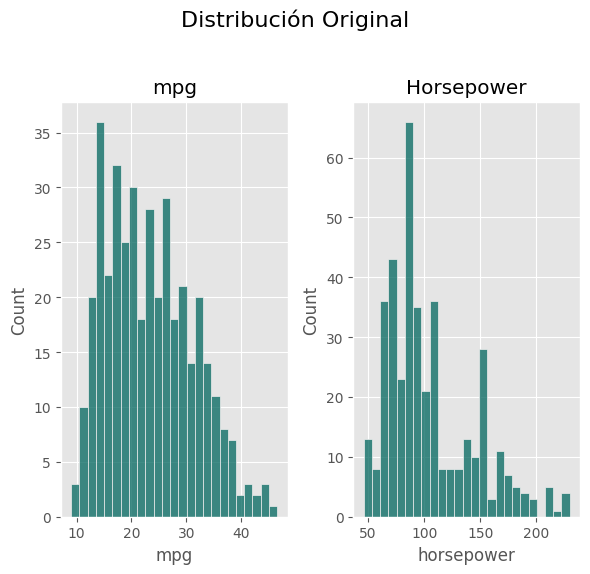

In [520]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(datos["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(datos["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución Original", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [521]:
tratamiento1.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,391.00,391.00,391.00,391.00,391.00,391.00,391.00,391.00
mean,23.46,5.47,194.12,104.40,2976.24,15.55,75.99,1.58
std,7.81,1.70,104.62,38.52,850.07,2.76,3.68,0.81
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2224.50,13.80,73.00,1.00
50%,23.00,4.00,151.00,93.00,2800.00,15.50,76.00,1.00
75%,29.00,8.00,264.50,125.00,3616.50,17.05,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


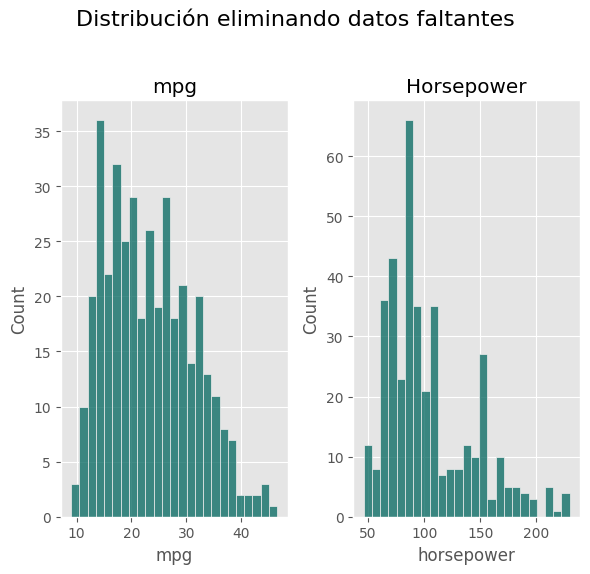

In [522]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento1["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento1["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución eliminando datos faltantes", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [523]:
tratamiento2.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,405.00,405.00,405.00,405.00,405.00,405.00,405.00,405.00
mean,23.06,5.47,194.50,103.46,2978.12,15.53,75.94,1.57
std,8.41,1.71,104.90,40.55,847.65,2.80,3.74,0.80
min,0.00,3.00,68.00,0.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2226.00,13.70,73.00,1.00
50%,22.40,4.00,151.00,93.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.00,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


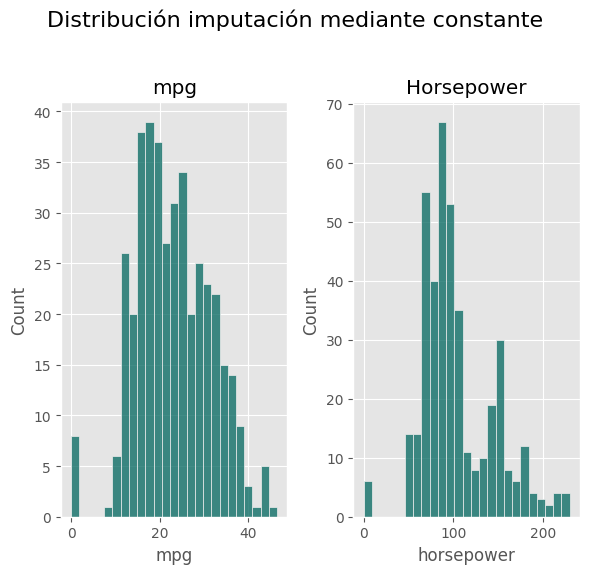

In [524]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento2["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento2["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución imputación mediante constante", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [525]:
tratamiento3.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,405.00,405.00,405.00,405.00,405.00,405.00,405.00,405.00
mean,23.32,5.47,194.50,105.69,2978.12,15.53,75.94,1.57
std,7.88,1.71,104.90,38.89,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,76.00,2226.00,13.70,73.00,1.00
50%,22.40,4.00,151.00,95.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,132.00,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


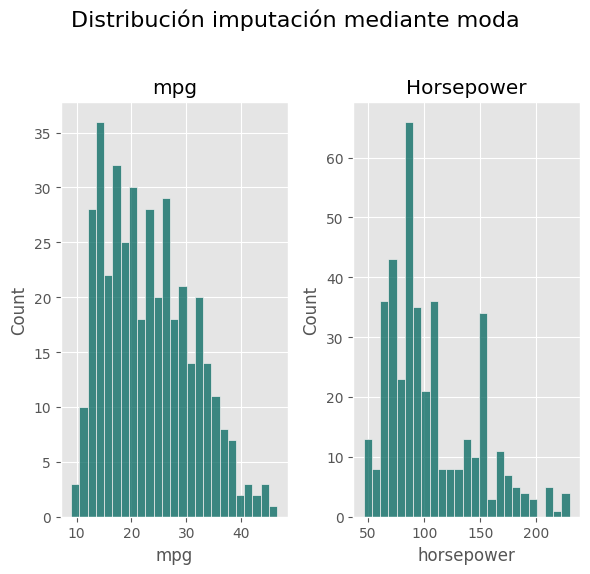

In [526]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento3["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento3["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución imputación mediante moda", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [527]:
tratamiento4.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,405.00,405.00,405.00,405.00,405.00,405.00,405.00,405.00
mean,23.40,5.47,194.50,104.60,2978.12,15.53,75.94,1.57
std,7.85,1.71,104.90,38.71,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2226.00,13.70,73.00,1.00
50%,23.00,4.00,151.00,94.75,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.00,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


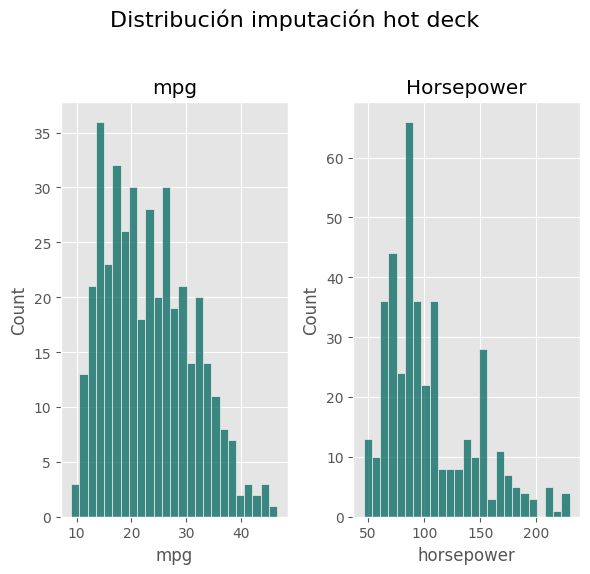

In [528]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento4["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento4["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución imputación hot deck", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [529]:
tratamiento5.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,405.00,405.00,405.00,405.00,405.00,405.00,405.00,405.00
mean,23.46,5.47,194.50,104.68,2978.12,15.53,75.94,1.57
std,7.88,1.71,104.90,38.65,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.00,4.00,105.00,75.00,2226.00,13.70,73.00,1.00
50%,23.00,4.00,151.00,94.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.00,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


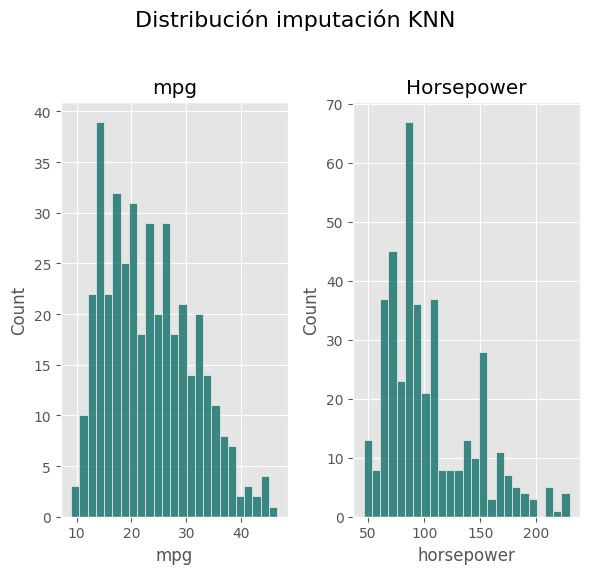

In [530]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento5["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento5["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución imputación KNN", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [531]:
tratamiento6.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,405.00,405.00,405.00,405.00,405.00,405.00,405.00,405.00
mean,23.53,5.47,194.50,105.02,2978.12,15.53,75.94,1.57
std,7.74,1.71,104.90,38.51,847.65,2.80,3.74,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,105.00,76.00,2226.00,13.70,73.00,1.00
50%,23.00,4.00,151.00,95.00,2815.00,15.50,76.00,1.00
75%,29.00,8.00,302.00,129.00,3620.00,17.20,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


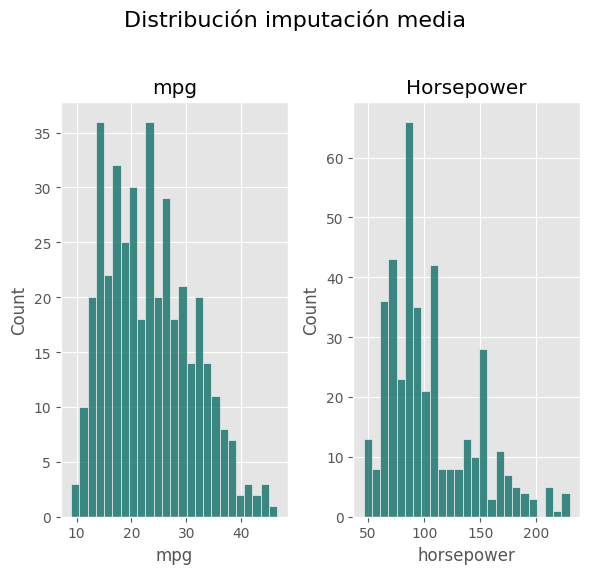

In [532]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

sns.histplot(tratamiento6["mpg"], color = "#01665e", bins = 25, ax = ax[0])
ax[0].set_title("mpg")

sns.histplot(tratamiento6["horsepower"], color = "#01665e", bins = 25, ax = ax[1])
ax[1].set_title("Horsepower")

fig.suptitle("Distribución imputación media", fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Teniendo en cuenta todos los resultados anteriores podemos obtener tanto conclusiones gráficos como analíticas. En particular destacamos lo siguiente:

*   Los mejores resultados se encuentran en los métodos de Hot-Deck, KNN e imputando mediante la media. Es importante resaltar que técnicas más avanzadas como KNN y Hot-Deck presentan resultados muy similares a un procedimiento simple como imputar utilizando la media, sin embargo, es probable que esto ocurra debido a que no tenemos muchos datos faltantes por lo que al imputar utilizando la estimación de la media la distribución no se ve muy afectada.

*   El resultado más pobre es cuando utilizamos una constante para imputar, es cuando la media y la desviación estándar de las columnas presenta un mayor cambio, también visualmente es donde se presenta el mayor cambio en el histograma, por ejemplo, podemos ver como el lado izquierdo del histograma de "mpg" y "horsepower" se ve bastante afectado por la imputación, por lo que preferimos otras técnicas que mantienen en mayor medida la distribución original
